In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
path = '/content/drive/My Drive/Datasets/DataOut/bus_trip_all_points_with_acceleration_and_radial_acceleration_and_distance.csv'

In [152]:
data = pd.read_csv(path)
data['devicetime'] = pd.to_datetime(data['devicetime'])


In [153]:
copy_for_later_use = data.copy()

In [154]:
path = '/content/drive/My Drive/Datasets/DataOut/bus_trips.csv'
all_trips_data = pd.read_csv(path)


# Clustering


In [155]:
# grouped_by_trip_id = datain_one_direction.groupby('trip_id')

# #get number of rows in each trip
# trip_id_count = grouped_by_trip_id['trip_id'].count()

In [156]:

# plt.hist(trip_id_count, bins=100)

In [157]:
#import trendypy as Trendy

In [158]:

from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from tslearn.utils import to_time_series_dataset
from tslearn.barycenters import softdtw_barycenter

In [159]:
# data = copy_for_later_use.copy()


In [160]:
data['time'] = pd.to_datetime(data['time'])
data['devicetime'] = pd.to_datetime(data['devicetime'])



In [161]:
# Round the distance_from_start column to the nearest hundred
data['100m_segment'] = (data['distance_from_start'] // 100)

# Create a new column called bus_behavior that captures the bus behavior
data['acceleration_category'] = 1 #medium
data.loc[data['acceleration'] > 1, 'acceleration_category'] = 2
data.loc[data['acceleration'] < -1, 'acceleration_category'] = -2
data.loc[data['acceleration'] < -2, 'acceleration_category'] = -3  #braking
data.loc[abs(data['acceleration']) < 0.2, 'acceleration_category'] = 0
# Bin the speed values into slow, medium, and fast categories
bins = [0, 0.5 , 10, 20, np.inf]
labels = [0,1,2,3] #idling , slow , medium , fast
data['speed_category'] = pd.cut(data['speed'], bins=bins, labels=labels)

# Assign acceleration_category and speed_category as floats
data['acceleration_category'] = data['acceleration_category'].astype(float)
data['speed_category'] = data['speed_category'].astype(float)


In [162]:


data['weekend'] = (data['devicetime'].dt.dayofweek) > 5
data['hour_of_day'] = data['devicetime'].dt.hour
data['trip_start_time'] = data.groupby('trip_id')['hour_of_day'].transform('first')# Define the bin edges for the start hour
bin_edges = [0, 6, 8, 12, 16, 20, 24]

# Use pd.cut to put the start hour into different bins
data['start_hour_bin'] = data.groupby('trip_id')['trip_start_time'].transform(lambda x: pd.cut(x, bins=bin_edges, labels=['0-6', '6-8', '8-12', '12-16', '16-20', '20-24']).cat.codes)


In [163]:
grouped_data = data.groupby([ 'direction', 'weekend','start_hour_bin'])

data_array = []
processed_trip_ids = []
for group_name,group_data in grouped_data:


  segment_groups = group_data.groupby('100m_segment')
  segment_averages = segment_groups.agg(
      {
      'speed_category':'mean',
      'acceleration_category':'mean',
      'radial_acceleration' : 'mean',
      })

  # Group by trip_id and 100m_segment and calculate the mean values
  trip_groups = group_data.groupby('trip_id')
  for trip_id, trip_data in trip_groups:
      processed_trip_ids.append(trip_id)

      trip_segment_groups = trip_data.groupby('100m_segment')
      trip_segment_averages = trip_segment_groups.agg(
          {
              'speed_category': 'mean',
              'acceleration_category': 'mean',
              'radial_acceleration': 'mean',
          }
      )

      trip_segment_averages = trip_segment_averages.iloc[:160]
      segment_averages = segment_averages.iloc[:160]

      # Interpolate missing values
      trip_segment_averages = trip_segment_averages.interpolate()
      segment_averages = segment_averages.interpolate()

      behaviour_data = trip_segment_averages-segment_averages

      data_array.append(behaviour_data)

In [164]:
print(data[['trip_id', 'start_hour_bin']])

        trip_id  start_hour_bin
0           2.0               1
1           2.0               1
2           2.0               1
3           2.0               1
4           2.0               1
...         ...             ...
297117   1365.0               4
297118   1365.0               4
297119   1365.0               4
297120   1365.0               4
297121   1365.0               4

[297122 rows x 2 columns]


In [166]:
X = to_time_series_dataset(data_array)

In [167]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Normalize the time series in X using mean-variance scaling
X_normalized = TimeSeriesScalerMeanVariance().fit_transform(X)


In [168]:
cluster_count = 4
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

ts_model = TimeSeriesKMeans(n_clusters=cluster_count, metric='dtw', max_iter=50, verbose=1, random_state=0)

cluster_labels = ts_model.fit_predict(X_normalized)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.6s


In [169]:
cluster_labels[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [170]:
from joblib import dump

# Create a TimeSeriesKMeans model
model = ts_model

# Save the model to a file
dump(model, '/content/drive/MyDrive/model2brakes_.joblib')

['/content/drive/MyDrive/model2brakes_.joblib']

In [172]:
X.shape

(1365, 160, 3)

In [182]:
X.shape

(1365, 160, 3)

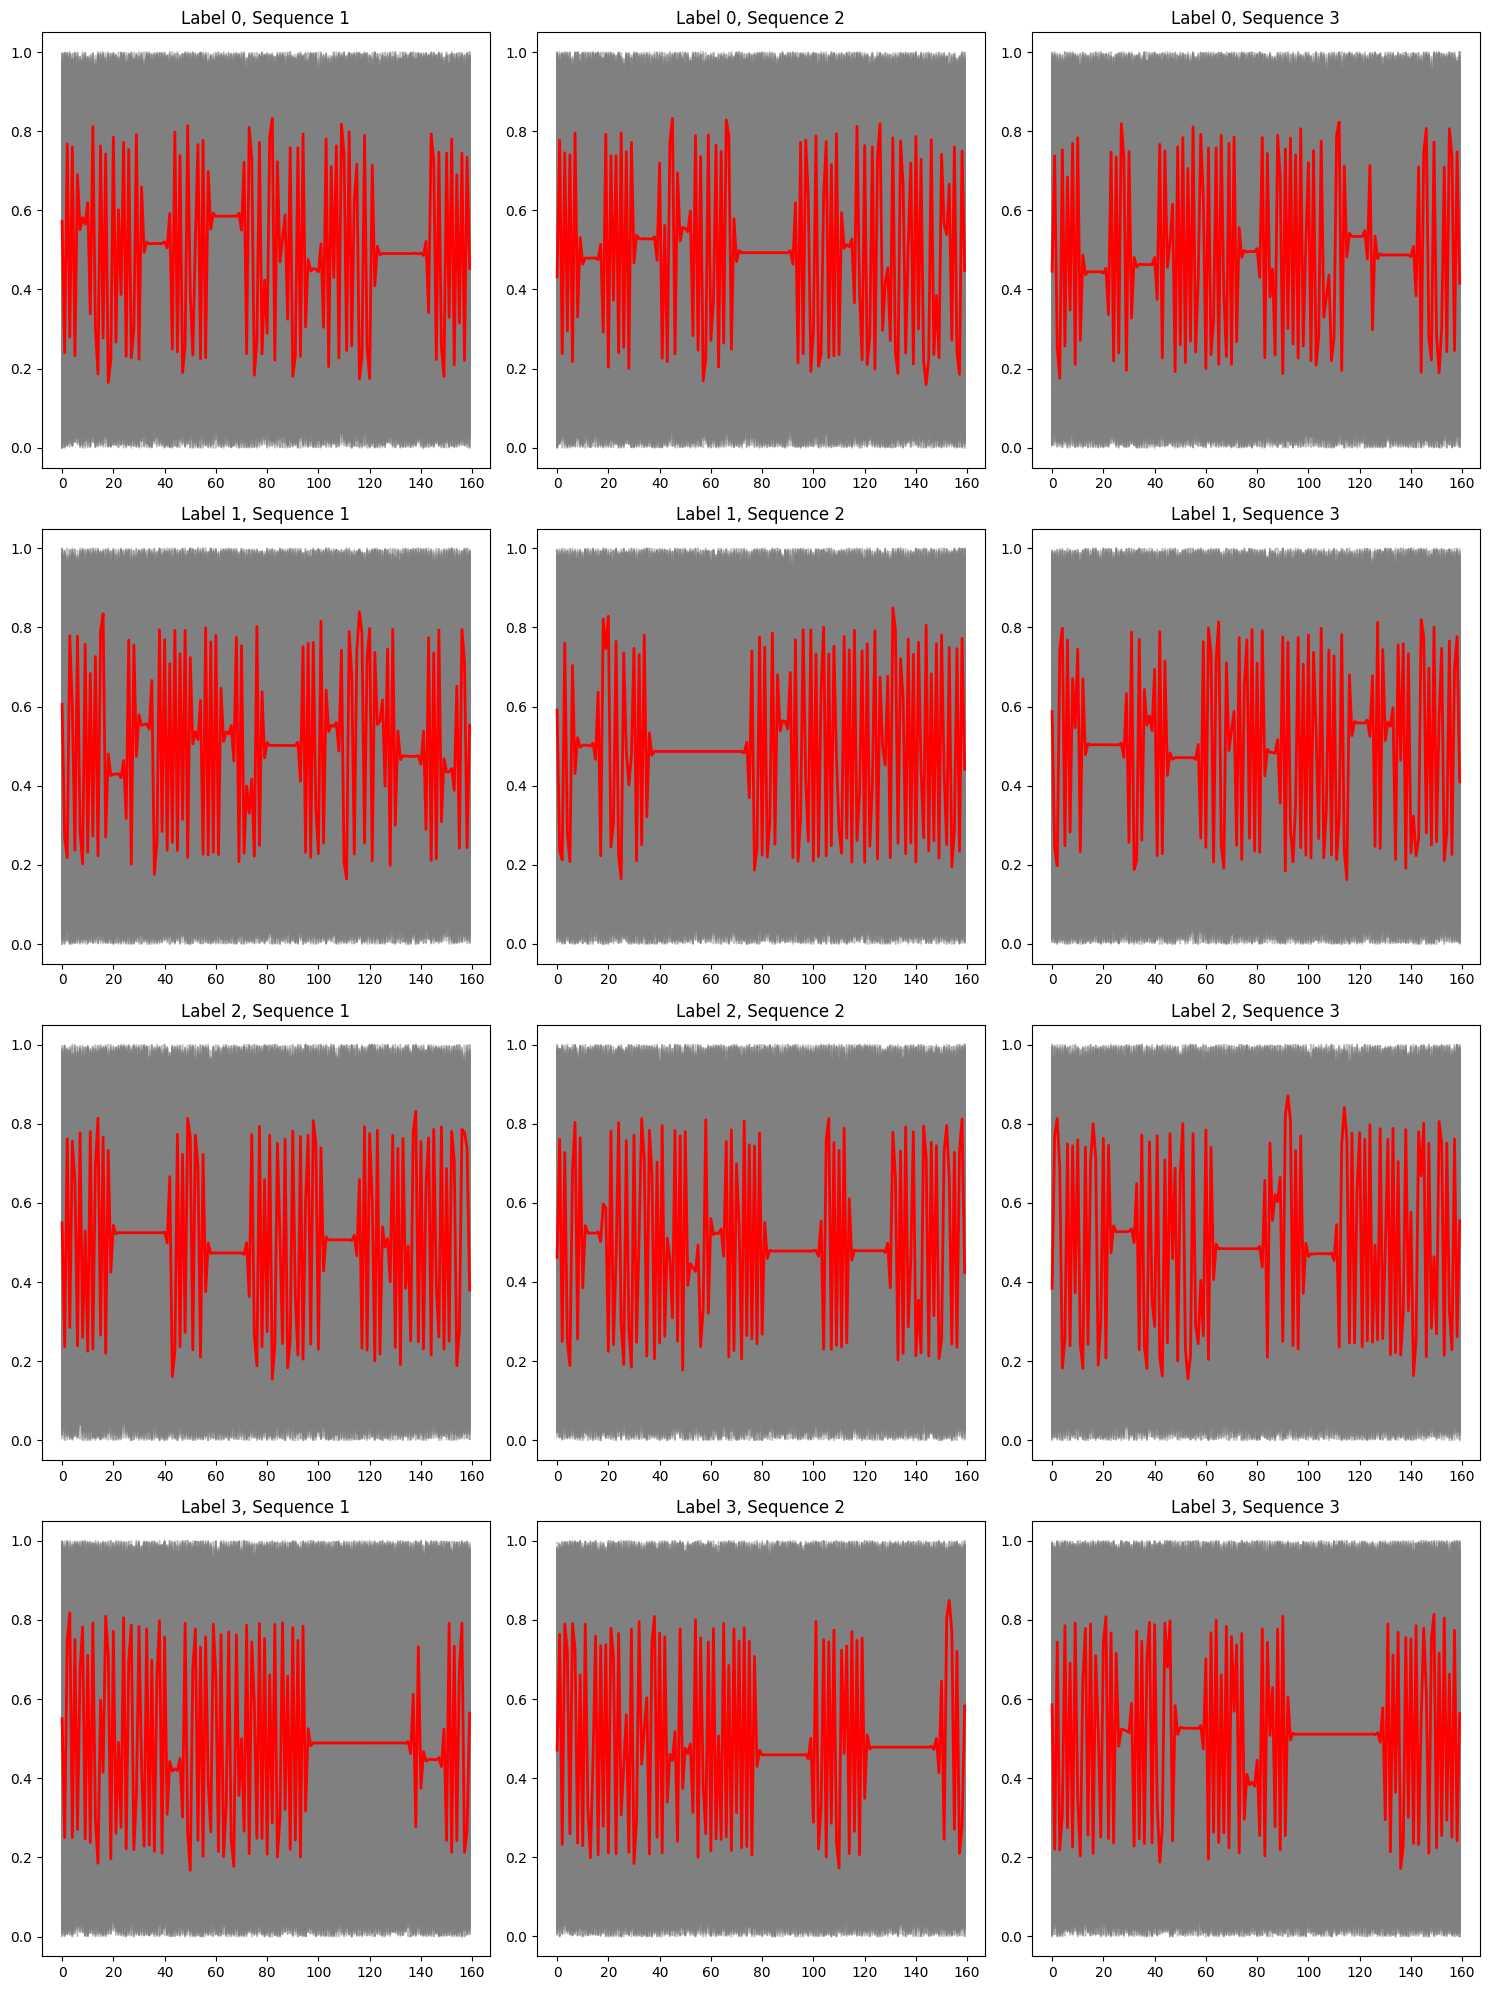

In [183]:

# Assuming X is a numpy array of shape (num_trips, 3, seq_length)
# and y is a numpy array of shape (num_trips,) containing the cluster labels

y = np.array(cluster_labels)
num_labels = 4  # Number of unique cluster labels
fig, axs = plt.subplots(num_labels, 3, figsize=(15, 5*num_labels))

for label in range(num_labels):
    # Get indices of trips with current label
    label_indices = np.where(y == label)[0]

    for i in range(3):
        # Get sequences for current trip and current sequence
        sequences = X[label_indices, :, i]

        # Compute barycenter using DTW
        barycenter = dtw_barycenter_averaging(sequences)

        # Plot sequences and barycenter
        axs[label, i].plot(sequences.T, color='gray', alpha=0.5)
        axs[label, i].plot(barycenter, color='red', linewidth=2)
        axs[label, i].set_title(f"Label {label}, Sequence {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
# Assuming you have a numpy array of cluster labels called 'y' and a list of trip_ids called 'trip_ids'

cluster_labels = dict(zip(trip_ids, y))

In [ ]:
import pickle

# Save dictionary to file
with open('cluster_labels.pkl', 'wb') as f:
    pickle.dump(cluster_labels, f)

In [ ]:
# Load dictionary from file
with open('cluster_labels.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)

In [ ]:
all_cluster_data = []
for label in range(4):

  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  cluster = []
  for i in range(len(processed_trip_ids)):

    if cluster_labels[i] != label:
        continue
    trip_id_i = processed_trip_ids[i]

    trip_df_i = data[data["trip_id"] == trip_id_i]
    y = trip_df_i['distance_from_start'].values
    x = pd.to_datetime(trip_df_i['devicetime']) - pd.to_datetime(trip_df_i['trip_start_time'])
    x = x.dt.total_seconds()
    columnx = "starting_time"
    columny = "distance_from_start"
    color = "grey"

    plt.xlabel(f"{columnx}")
    plt.ylabel(f"{columny}")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  #


    plt.plot(x,y,color = "grey",alpha = 0.4)

    cluster.append((x,y))

  # avg_time_series = ts_model.cluster_centers_[label]
  # # Extract the two columns
  # x = avg_time_series[:, 0]
  # y = avg_time_series[:, 1]

  # all_cluster_data.append(avg_time_series)
  # plt.plot(x, y, color = "red")
  # plt.xlim(0, 17500)
  # plt.ylim(0,4)
  plt.show()

In [ ]:
starting_hour_grouped = data.groupby("trip_start_time")
for bin , starting_hour_group  in starting_hour_grouped:
  all_cluster_data = []
  all_cluster_data = []
for label in range(4):

  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  cluster = []
  for i in range(len(processed_trip_ids)):

    if cluster_labels[i] != label:
        continue
    trip_id_i = processed_trip_ids[i]

    trip_df_i = data[data["trip_id"] == trip_id_i]
    y = trip_df_i['distance_from_start'].values
    x = pd.to_datetime(trip_df_i['devicetime']) - pd.to_datetime(trip_df_i['trip_start_time'])
    x = (x.total_seconds())/60
    columnx = "duration in minutes"
    columny = "distance_from_start"
    color = "grey"

    plt.xlabel(f"{columnx}")
    plt.ylabel(f"{columny}")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  #


    plt.plot(x,y,color = "grey",alpha = 0.4)

    cluster.append((x,y))

  # avg_time_series = ts_model.cluster_centers_[label]
  # # Extract the two columns
  # x = avg_time_series[:, 0]
  # y = avg_time_series[:, 1]

  # all_cluster_data.append(avg_time_series)
  # plt.plot(x, y, color = "red")
  # plt.xlim(0, 17500)
  # plt.ylim(0,4)
  plt.show()


In [ ]:
all_trips_data

In [ ]:
df = data_in_one_direction

In [ ]:
all_trips_data

In [ ]:

merged_data = df.merge(all_trips_data[['trip_id', 'cluster_label']], on='trip_id', how='left')

In [ ]:
merged_data.head()

In [ ]:
for feature in ['acceleration', 'speed', 'radial_acceleration'] :
  averages = merged_data.groupby(['cluster_label','direction'])[feature].mean()
  print(averages)

In [ ]:
merged_data['breaks'] = data['acceleration'].apply(lambda x: 1 if x < -2 else 0)


In [ ]:
#

In [ ]:
# import matplotlib.pyplot as plt
# import math


# plot_count = math.ceil(math.sqrt(cluster_count))

# fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
# fig.suptitle('Clusters')
# row_i=0
# column_j=0
# # For each label there is,
# # plots every series with that label
# for label in set(labels):
#     cluster = []
#     for i in range(len(labels)):
#             if(labels[i]==label):
#                 axs[row_i, column_j].plot(X[i],c="gray",alpha=0.4)
#                 cluster.append(X[i])
#     if len(cluster) > 0:
#         axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")

#     column_j+=1
#     if column_j%plot_count == 0:
#         row_i+=1
#         column_j=0

# plt.show()

In [ ]:
## performDBA function



'''
/*******************************************************************************
 * Copyright (C) 2018 Francois Petitjean
 *
 * This program is free software: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation, version 3 of the License.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU General Public License for more details.
 *
 * You should have received a copy of the GNU General Public License
 * along with this program.  If not, see <http://www.gnu.org/licenses/>.
 ******************************************************************************/
'''
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce


__author__ ="Francois Petitjean"

def performDBA(series, n_iterations=10):
    n_series = len(series)
    max_length = 0
    for s in series:
        max_length = max(max_length,s.shape[1])

    cost_mat = np.zeros((max_length, max_length))
    delta_mat = np.zeros((max_length, max_length))
    tmp_delta_mat = np.zeros((max_length, max_length))
    path_mat = np.zeros((max_length, max_length), dtype=np.int8)

    medoid_ind = approximate_medoid_index(series,cost_mat,delta_mat,tmp_delta_mat)
    center = series[medoid_ind]

    for i in range(0,n_iterations):
        center = DBA_update(center, series, cost_mat, path_mat, delta_mat,tmp_delta_mat)

    return center

def approximate_medoid_index(series,cost_mat,delta_mat,tmp_delta_mat):
    if len(series)<=50:
        indices = range(0,len(series))
    else:
        indices = np.random.choice(range(0,len(series)),50,replace=False)

    medoid_ind = -1
    best_ss = 1e20
    for index_candidate in indices:
        candidate = series[index_candidate]
        ss = sum_of_squares(candidate,series,cost_mat,delta_mat,tmp_delta_mat)
        if(medoid_ind==-1 or ss<best_ss):
            best_ss = ss
            medoid_ind = index_candidate
    return medoid_ind

def sum_of_squares(s,series,cost_mat,delta_mat,tmp_delta_mat):
    return sum(map(lambda t:squared_DTW(s,t,cost_mat,delta_mat,tmp_delta_mat),series))

def DTW(s,t,cost_mat,delta_mat):
    return np.sqrt(squared_DTW(s,t,cost_mat,delta_mat))

def squared_DTW(s,t,cost_mat,delta_mat,tmp_delta_mat):
    s_len = s.shape[1]
    t_len = t.shape[1]
    fill_delta_mat_dtw(s, t, delta_mat,tmp_delta_mat)
    cost_mat[0, 0] = delta_mat[0, 0]
    for i in range(1, s_len):
        cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]

    for j in range(1, t_len):
        cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]

    for i in range(1, s_len):
        for j in range(1, t_len):
            diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
            if(diag <=left):
                if(diag<=top):
                    res = diag
                else:
                    res = top
            else:
                if(left<=top):
                    res = left
                else:
                    res = top
            cost_mat[i, j] = res+delta_mat[i, j]
    return cost_mat[s_len-1,t_len-1]

def fill_delta_mat_dtw(center, s, delta_mat, tmp_delta_mat):
    n_dims = center.shape[0]
    len_center = center.shape[1]
    len_s=  s.shape[1]
    slim = delta_mat[:len_center,:len_s]
    slim_tmp = tmp_delta_mat[:len_center,:len_s]

    #first dimension - not in the loop to avoid initialisation of delta_mat
    np.subtract.outer(center[0], s[0],out = slim)
    np.square(slim, out=slim)

    for d in range(1,center.shape[0]):
        np.subtract.outer(center[d], s[d],out = slim_tmp)
        np.square(slim_tmp, out=slim_tmp)
        np.add(slim,slim_tmp,out=slim)

    assert(np.abs(np.sum(np.square(center[:,0]-s[:,0]))-delta_mat[0,0])<=1e-6)

def DBA_update(center, series, cost_mat, path_mat, delta_mat, tmp_delta_mat):
    options_argmin = [(-1, -1), (0, -1), (-1, 0)]
    updated_center = np.zeros(center.shape)
    center_length = center.shape[1]
    n_elements = np.zeros(center_length, dtype=int)

    for s in series:
        s_len = s.shape[1]
        fill_delta_mat_dtw(center, s, delta_mat, tmp_delta_mat)
        cost_mat[0, 0] = delta_mat[0, 0]
        path_mat[0, 0] = -1

        for i in range(1, center_length):
            cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]
            path_mat[i, 0] = 2

        for j in range(1, s_len):
            cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]
            path_mat[0, j] = 1

        for i in range(1, center_length):
            for j in range(1, s_len):
                diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
                if(diag <=left):
                    if(diag<=top):
                        res = diag
                        path_mat[i,j] = 0
                    else:
                        res = top
                        path_mat[i,j] = 2
                else:
                    if(left<=top):
                        res = left
                        path_mat[i,j] = 1
                    else:
                        res = top
                        path_mat[i,j] = 2

                cost_mat[i, j] = res+delta_mat[i, j]

        i = center_length-1
        j = s_len-1

        while(path_mat[i, j] != -1):
            updated_center[:,i] += s[:,j]
            n_elements[i] += 1
            move = options_argmin[path_mat[i, j]]
            i += move[0]
            j += move[1]
        assert(i == 0 and j == 0)
        updated_center[:,i] += s[:,j]
        n_elements[i] += 1

    return np.divide(updated_center, n_elements)

# def main():
#     #generating synthetic data
#     n_series = 20
#     length = 200
#     n_dims = 201

#     print('Important note: the data should be structure "channels-first", ie the series should have shape (n_channels,length)')

#     series = list()
#     padding_length=30
#     indices = range(0, length-padding_length)
#     main_profile_gen = np.array([np.sin(2.0*np.pi*j/len(indices)) for j in indices])

#     randomizer = lambda j:np.random.normal(j,0.02)
#     randomizer_fun = np.vectorize(randomizer)
#     for i in range(0,n_series):
#         n_pad_left = np.random.randint(0,padding_length)
#         #adding zero at the start or at the end to shif the profile
#         b = n_pad_left
#         a = padding_length-n_pad_left
#         padded_pattern = np.pad(main_profile_gen,(a,b),mode='constant',constant_values=0)

#         #chop some of the end to prove it can work with multiple lengths
#         l = np.random.randint(length-20,length+1)
#         padded_pattern = padded_pattern[:l]
#         padded_pattern = randomizer_fun(padded_pattern)

#         series_i = np.zeros((n_dims,l))
#         for d in range(0,n_dims):
#             series_i[d]=padded_pattern

#         series.append(series_i)

#     #plotting the synthetic data
#     for s in series:
#         plt.plot(range(0,s.shape[1]), s[0])
#     plt.draw()
#     plt.show()

#     #calculating average series with DBA
#     average_series = performDBA(series)

#     #plotting the average series
#     plt.figure()
#     for d in range(0,n_dims):
#         plt.plot(range(0,average_series.shape[1]), average_series[d])
#     plt.show()

# if __name__== "__main__":
#     main()

In [ ]:
#

## Visualize bus running on map

In [ ]:
## Visulaise bus running on map

import folium
import pandas as pd
from ipywidgets import interact, IntSlider



# Convert timestamp column to datetime format
data['devicetime'] = pd.to_datetime(data['devicetime'])

data['devicetime'].min()
from geopy.geocoders import Nominatim

# Create a geolocator object
geolocator = Nominatim(user_agent="my_geocoder")

# Get the location coordinates (latitude, longitude) for Kandy
Nattarampota_location = geolocator.geocode("Nattarampota, Sri Lanka")
Nattarampota_latitude = Nattarampota_location.latitude
Nattarampota_longitude = Nattarampota_location.longitude

print("Latitude:", Nattarampota_latitude, "Longitude:", Nattarampota_longitude)
Nattarampota_location = [Nattarampota_latitude, Nattarampota_longitude]  # Kandy city location
from geopy.geocoders import Nominatim

# Create a geolocator object
geolocator = Nominatim(user_agent="my_geocoder")

# Get the location coordinates (latitude, longitude) for Kandy
kandy_location = geolocator.geocode("Kandy, Sri Lanka")
kandy_latitude = kandy_location.latitude
kandy_longitude = kandy_location.longitude

print("Latitude:", kandy_latitude, "Longitude:", kandy_longitude)
Kandy_location = [kandy_latitude, kandy_longitude]  # Kandy city location
from geopy.geocoders import Nominatim

# Create a geolocator object
geolocator = Nominatim(user_agent="my_geocoder")

# Get the location coordinates (latitude, longitude) for digana
digana_location = geolocator.geocode("Digana, Sri Lanka")
digana_latitude = digana_location.latitude
digana_longitude = digana_location.longitude

print("Latitude:", digana_latitude, "Longitude:", digana_longitude)
digana_location = [digana_latitude, digana_longitude]  # Kandy city location
data.head(20)
import folium
import pandas as pd
from shapely.geometry import Point
from ipywidgets import FloatSlider, interact, Label, Output, VBox, Button, HBox

# Assuming you have 'data' DataFrame containing bus data

# Dictionary to store last known location of each bus
bus_locations = {}

# Create Point geometries for Kandy and Digana
kandy_location = Point(kandy_latitude, kandy_longitude)
digana_location = Point(digana_latitude, digana_longitude)  # Define the coordinates for Digana

def create_map():
    return folium.Map(location=Nattarampota_location, zoom_start=14)

def update_map(timestamp):
    m = create_map()  # Create a new map instance each time
    interval = pd.Timedelta(seconds=15)
    timestamp_dt = pd.Timestamp.fromtimestamp(timestamp)  # Convert timestamp to pandas Timestamp
    interval_start = timestamp_dt - interval / 2
    interval_end = timestamp_dt + interval / 2

    bus_data_within_interval = data[(data['devicetime'] >= interval_start) & (data['devicetime'] <= interval_end)]
    bus_data_within_interval = bus_data_within_interval.sort_values(by='devicetime', ascending=False)
    unique_buses = data['deviceid'].unique()

    for deviceid in unique_buses:
        latest_data_for_bus = None  # Initialize the variable here

        bus_data_for_bus = bus_data_within_interval[bus_data_within_interval['deviceid'] == deviceid]
        if len(bus_data_for_bus) > 0:
            latest_data_for_bus = bus_data_for_bus.iloc[0]
            bus_location = [latest_data_for_bus['latitude'], latest_data_for_bus['longitude']]
            bus_locations[deviceid] = bus_location
        else:
            bus_location = bus_locations.get(deviceid)

        if bus_location is not None:
            bus_point = Point(bus_location[0], bus_location[1])

            # Adjust the color using a consistent formula
            color = "#{:06x}".format(deviceid + 100000)

            # get speed acceleration and radial acceleration into three variables
            if latest_data_for_bus is not None:
                speed = latest_data_for_bus['speed']
                acceleration = latest_data_for_bus['acceleration']
                radial_acceleration = latest_data_for_bus['radial_acceleration']
                print(speed, acceleration, radial_acceleration)
            else:
                speed = 0
                acceleration = 0
                radial_acceleration = 0

            folium.Marker(
                location=bus_location,
                popup=[deviceid, speed, acceleration, radial_acceleration],
                color=color  # Use the calculated color
            ).add_to(m)

    return m

min_timestamp = data['devicetime'].min()
max_timestamp = data['devicetime'].max()

# Calculate step size in seconds
step_size_seconds = 15
slider = FloatSlider(value=min_timestamp.timestamp(), min=min_timestamp.timestamp(), max=max_timestamp.timestamp(), step=step_size_seconds)

# Adjust the length of the slider using CSS style
slider.style.handle_length = '500px'  # Adjust the length as desired

time_label = Label(value=pd.Timestamp.fromtimestamp(slider.value).strftime('%Y-%m-%d %H:%M:%S'))

def update_time_label(change):
    time_label.value = pd.Timestamp.fromtimestamp(change['new']).strftime('%Y-%m-%d %H:%M:%S')

slider.observe(update_time_label, 'value')

stop = False  # Declare stop as a global variable

# Button to stop continuous play
def stop_continuous(_):
    global stop
    stop = True

# Button to move slider left
def move_left(_):
    slider.value -= step_size_seconds

# Button to move slider right
def move_right(_):
    slider.value += step_size_seconds

# Button to move slider left continuously
def move_left_continuous(_):
    while slider.value > slider.min and not stop:
        slider.value -= step_size_seconds

# Button to move slider right continuously
def move_right_continuous(_):
    while slider.value < slider.max and not stop:
        slider.value += step_size_seconds





left_button = Button(description='<<', icon='angle-left')
right_button = Button(description='>>', icon='angle-right')
left_continuous_button = Button(description='Continuous <<', icon='step-backward')
right_continuous_button = Button(description='Continuous >>', icon='step-forward')
stop_button = Button(description='Stop', icon='stop')

left_button.on_click(move_left)
right_button.on_click(move_right)
left_continuous_button.on_click(move_left_continuous)
right_continuous_button.on_click(move_right_continuous)
stop_button.on_click(stop_continuous)

buttons_row = HBox([left_button, left_continuous_button, right_button, right_continuous_button, stop_button])
controls_box = VBox([buttons_row, slider, time_label])

out_map = Output()
out_map.layout.height = '600px'  # Adjust the height as desired

def update_map_output(change):
    with out_map:
        out_map.clear_output(wait=True)
        display(update_map(slider.value))

slider.observe(update_map_output, 'value')

app_layout = VBox([controls_box, out_map])

display(app_layout)

